### Harmonize survey results

#### Seperates the survey data into object counts, uses location and date as survey identifier.

seasonal dates: sep-november and april-june each year
water features: all lakes and rivers in the Rheine catchment area

Specifically: not including the Maass

Fetches data from the local source and establishes the following variables:

1. dutch_codes
2. swiss_codes
3. dutch_surveys
4. swiss_surveys
5. swiss_beaches


Establishes directory variables for fetching and putting to all subdirectories:

1. data
2. beaches
3. codes
4. geo
5. output

provides a script to update the remote data.

In [1]:
# sys things
import os
import sys
import json

# networks
import requests

# data
import pandas as pd
import numpy as np
import datetime as dt
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import display, Markdown, Latex, HTML

# mapping
import geopandas as gpd

# home brew utitilties
import resources.utilities.utility_functions as ut

# documenting
from IPython.display import Markdown as md


title_k = {'loc':'left', 'pad':12, 'linespacing':1.5, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}

# use these to format date axis in charts
weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

months = mdates.MonthLocator(bymonth=[3,6,9,12])
bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
allmonths = mdates.MonthLocator()
wks_fmt = mdates.DateFormatter('%d')
mths_fmt = mdates.DateFormatter('%b')

In [2]:
# get folder extesions
data, beaches, codes, geo, output=ut.make_local_paths()
print("look for resources here\n")
print(data, beaches, codes, geo, output)

look for resources here

resources/surveydata resources/locationdata resources/mlwcodedefs resources/geodata output


In [3]:
project_directory = ut.make_project_folder(output, "harmonized_results")
print("put stuff here:\n")
print(project_directory)

put stuff here:

output/harmonized_results


In [4]:
# survey_data
dutch_surveys = pd.read_csv(data+'/dataset_macrolitter_NL.csv')

# use the aggregated hd data. This accounts for the custom codes used in Switzerland
swiss_surveys = pd.read_csv(data+'/aggregated_hd_surveys.csv')

# location data
swiss_beaches = pd.read_csv(beaches+'/hammerdirt_beaches.csv')

In [5]:
print("Columns from cleaned up dutch data\n")
print(dutch_surveys.columns)

print("\nColumns from cleaned up swiss data\n")
print(swiss_surveys.columns)

Columns from cleaned up dutch data

Index(['Unnamed: 0', 'Gebiedscode', 'Rivier', 'Coordinaten', 'Lat', 'Lon',
       'meting', 'date', 'doy', 'dop',
       ...
       'sanitair_tissues_wc_papier', 'sanitair_toiletverfrissers',
       'sanitair_overig_sanitair', 'medisch_verpakkingen', 'medisch_spuiten',
       'medisch_overig_medisch', 'Unnamed: 121', 'Totaal', 'Items/km',
       'granulaat_korrels'],
      dtype='object', length=125)

Columns from cleaned up swiss data

Index(['loc_date', 'code', 'date', 'pcs_m', 'quantity', 'location',
       'water_name'],
      dtype='object')


In [6]:
print("the first ten rows are admin data\n")
print(dutch_surveys.columns[:10])
print("\nthe next 115 is code data\n")
print(dutch_surveys.columns[10:])
print("\none row is equal to one survey")

the first ten rows are admin data

Index(['Unnamed: 0', 'Gebiedscode', 'Rivier', 'Coordinaten', 'Lat', 'Lon',
       'meting', 'date', 'doy', 'dop'],
      dtype='object')

the next 115 is code data

Index(['plastic_6_packringen', 'plastic_tassen',
       'plastic_kleine_plastic_tasjes',
       'plastic_drankflessen_groterdan_halveliter',
       'plastic_drankflessen_kleinerdan_halveliter',
       'plastic_wikkels_van_drankflessen',
       'plastic_verpakking_van_schoonmaakmiddelen',
       'plastic_voedselverpakkingen_frietbakjes_etc',
       'plastic_cosmeticaverpakkingen',
       'plastic_motorolieverpakking_groterdan50cm',
       ...
       'sanitair_tissues_wc_papier', 'sanitair_toiletverfrissers',
       'sanitair_overig_sanitair', 'medisch_verpakkingen', 'medisch_spuiten',
       'medisch_overig_medisch', 'Unnamed: 121', 'Totaal', 'Items/km',
       'granulaat_korrels'],
      dtype='object', length=115)

one row is equal to one survey


In [7]:
print("This is the number of rows\n")
print(len(dutch_surveys))

This is the number of rows

391


In [8]:
# key the Gebiedscode to an int
count_gebied = {n:i+1 for i,n in enumerate(dutch_surveys.Gebiedscode.unique())}

# grab only the object count columns and the river
obj_counts = dutch_surveys.columns[10:-4]

In [9]:
# reformat the dutch dates to the same ISO standard as the swiss dates
# first make them strings
dutch_surveys['new date'] = dutch_surveys.date.map(lambda x: F"{x}")

# reformat and identify any non valid dates:
def make_this_a_date(x):
    a_date = F"{x}"
    if len(a_date) == 8:
        new_date = F"{a_date[:4]}-{a_date[4:6]}-{a_date[6:]}"
        try:
            a_date = dt.datetime.strptime(new_date, "%Y-%m-%d").date()
        except:
            a_date = 'nothing'
    else:
        a_date = 'nothing'
        
    return a_date

dutch_surveys['this date'] = dutch_surveys['new date'].map(lambda x: make_this_a_date(x))

# check for data with no dates
no_date_dutch_surveys =dutch_surveys[dutch_surveys['this date'] == 'nothing'].copy()

# drop the records with no valid dates
dutch_surveys = dutch_surveys[dutch_surveys['this date'] != 'nothing'].copy()

dutch_surveys['date'] = dutch_surveys['this date']
dutch_surveys.drop(['this date', 'new date'], inplace=True, axis=1)

### Identify the unique survey locations

1. use the lat/lon pairs for each survey
2. get the unique dates
3. assign a name to each unique lat/lon pair
4. assign a water feature name and type column
5. add admin columns

In [10]:
dutch_surveys['lat_lon'] = list(zip(dutch_surveys.Lat, dutch_surveys.Lon))
count_lat_lon = {n:i+1 for i,n in enumerate(dutch_surveys.lat_lon.unique())}
# dutch_surveys = dutch_surveys[dutch_surveys.Rivier == 'Maas']
print("The number of unique lat/lon pairs\n")
print(dutch_surveys.lat_lon.nunique())
print("\nThe number of unique lat values\n")
print(len(dutch_surveys.Lat.unique()))
print("\nThe number of unique lon values\n")
print(len(dutch_surveys.Lon.unique()))

The number of unique lat/lon pairs

192

The number of unique lat values

187

The number of unique lon values

190


In [11]:
# these columns are admin data
admin = ['lat_lon', 'Gebiedscode', 'Rivier', 'Coordinaten','Lat', 'Lon', 'meting']
date = ['date']

# unique id per row:
loc_date = ['lat_lon', 'date']

# these are no longer needed
no_longer_needed = ['Unnamed: 121', 'Totaal', 'Items/km', 'granulaat_korrels']

def make_location_groups(x, keys):
    try:
        name = keys[x]
    except:
        name = x
    return F"{name}"

# assign a place number for each lat/lon pair
dutch_surveys['name'] = dutch_surveys.lat_lon.map(lambda x: make_location_groups(x, count_lat_lon))

# prepend the river name to the place number, call it location
dutch_surveys['location'] = dutch_surveys.Rivier + dutch_surveys.name

# change the names of these columns to match the swiss data
dutch_surveys.rename(columns={'Lat':'latitude', 'Lon':'longitude', 'Rivier':'water_name'}, inplace=True)

# these columns are not needed
dutch_surveys.drop(['Coordinaten', 'meting'], axis=1, inplace=True)

# slugs make things easier
dutch_surveys['slug'] = dutch_surveys.location.map(lambda x: x.lower())

# create a loc_date column
dutch_surveys['loc_date'] = list(zip(dutch_surveys.slug, dutch_surveys.date))

# add some sorting and grouping columns
dutch_surveys['city'] = 'unk'
dutch_surveys['country'] = 'NL'
dutch_surveys['water'] = 'r'

admin_cols = ['location', 'latitude', 'longitude', 'city', 'country', 'water_name', 'water','lat_lon', 'slug', 'Gebiedscode']

# apply the new columns  and drop all the duplicates:
dutch_admin = dutch_surveys[admin_cols].copy()
dutch_admin = dutch_admin.drop_duplicates()

In [12]:
# save the dutch beaches
a_file_name = F"{beaches}/dutch_beaches.csv"
dutch_admin.to_csv(a_file_name, index=False)

print(F"This is the definition of Waal5:\n")
dutch_admin[dutch_admin.location == 'Waal1']

This is the definition of Waal5:



,location,latitude,longitude,city,country,water_name,water,lat_lon,slug,Gebiedscode
0,Waal1,51.8227,5.0159,unk,NL,Waal,r,"(51.8227, 5.0159)",waal1,W(078a)R-ZHNL


### Separate the survey results from the admin data

1. Create one row for each object record
2. Key by location and loc_date
3. Save results separately

In [13]:
# a place to store the results
new_results=[]

def seperate_results(x, a_list):
    # alist is the list of columns to keep
    # return x because we don't want to chage the df
    for element in a_list:
        stuff = {'location':x['slug'], 'date':x['date'], 'loc_date':x['loc_date'], 'water_name':x['water_name'], 'object':element, 'quantity':x[element], 'rate':x['Items/km']}
        new_results.append(stuff)
    return x

# apply
dutch_surveys.apply(lambda row: seperate_results(row, obj_counts), axis=1)

# make new df 
a_results_df = pd.DataFrame(new_results)

# convert to date and convert to pcs_m
a_results_df['date'] = pd.to_datetime(a_results_df['date'], format='%Y-%m-%d')
a_results_df['pcs_m'] = a_results_df.quantity/100
a_results_df.drop('rate', inplace=True, axis=1)

print(F"This is the object results with a  name tag and a loc_date tag\n")
a_results_df.head()

This is the object results with a  name tag and a loc_date tag



,location,date,loc_date,water_name,object,quantity,pcs_m
0,waal1,2017-10-21,"(waal1, 2017-10-21)",Waal,plastic_6_packringen,0.0,0.00
1,waal1,2017-10-21,"(waal1, 2017-10-21)",Waal,plastic_tassen,0.0,0.00
2,waal1,2017-10-21,"(waal1, 2017-10-21)",Waal,plastic_kleine_plastic_tasjes,2.0,0.02
3,waal1,2017-10-21,"(waal1, 2017-10-21)",Waal,plastic_drankflessen_groterdan_halveliter,0.0,0.00
4,waal1,2017-10-21,"(waal1, 2017-10-21)",Waal,plastic_drankflessen_kleinerdan_halveliter,1.0,0.01


In [14]:
print("The total by river\n")
print(a_results_df.groupby('water_name').quantity.sum())

The total by river

water_name
Maas         113043.0
Nederrijn      7279.0
Waal          30684.0
Name: quantity, dtype: float64


In [15]:
print("The total quantity\n")
print(a_results_df.quantity.sum())

The total quantity

151006.0


In [16]:
tops = a_results_df.groupby(['object']).quantity.sum()
tops = tops.sort_values(ascending=False)

print("The top ten objects:\n")
print(tops[:10])

The top ten objects:

object
plastic_plastic_stukjes_2_5_50cm_zacht_plastic    24023.0
plastic_plastic_stukjes_0_2_5cm_zacht_plastic     18008.0
plastic_piepschuim_0_2_5cm                        14944.0
plastic_snoep_snack_chipsverpakking               10587.0
plastic_piepschuim_2_5_50cm                       10558.0
plastic_plastic_stukjes_0_2_5cm_hard_plastic       9278.0
plastic_plastic_stukjes_2_5_50cm_hard_plastic      7581.0
plastic_doppen_en_deksels                          6923.0
plastic_voedselverpakkingen_frietbakjes_etc        3608.0
sanitair_plastic_wattenstaafjes                    3242.0
Name: quantity, dtype: float64


#### The column names need to be harmonized

In [17]:
print(F"These are the dutch column names:\n\n{a_results_df.columns}\n")
print(F"These are the swiss column names:\n\n{swiss_surveys.columns}\n")

These are the dutch column names:

Index(['location', 'date', 'loc_date', 'water_name', 'object', 'quantity',
       'pcs_m'],
      dtype='object')

These are the swiss column names:

Index(['loc_date', 'code', 'date', 'pcs_m', 'quantity', 'location',
       'water_name'],
      dtype='object')



In [18]:
# renaming the columns
a_results_df.rename(columns={'object':'code'}, inplace=True)
# a_results_df['pcs_m'] = a_results_df.quantity/100
a_results_df['pcs_m'] = a_results_df.pcs_m.round(3)

In [19]:
swiss_surveys.water_name.unique()

array(['Zurichsee', 'Aare', 'Aare|Nidau-Büren-Kanal', 'Lac Léman', 'Arve',
       'Lago Maggiore', 'Thunersee', 'Untersee', 'Bielersee', 'Birs',
       'Bodensee', 'Chriesbach', 'Emme', 'Neuenburgersee', 'Walensee',
       'Glatt', 'Goldach', 'Greifensee', 'Grändelbach', 'Brienzersee',
       'Inn', 'Jona', 'Katzensee', 'Dorfbach', 'La Thièle', 'Langeten',
       'Rhône', 'Limmat', 'Linthkanal', 'Escherkanal', 'Lorze',
       'Lötschebach', 'Murg', 'Ognonnaz', 'Pfaffnern', 'Reuss', 'Rhein',
       'Maggia', 'Schiffenensee', 'Schüss', 'Seez', 'Sempachsee', 'Sense',
       'Sihl', 'Sihlsee', 'Sitter', 'Thur', 'Töss', 'Urnäsch',
       'Quatre Cantons', 'Vorderrhein', 'Zugersee', 'Zulg'], dtype=object)

In [20]:
a_min_date = a_results_df['date'].min()
a_max_date = a_results_df['date'].max()
print(F"The min date: {a_min_date.date()}, the max date: {a_max_date.date()}")

# swiss water features
water_names = ['Aare', 'Sihl', 'Reuss', 'Rhein', 'Limmat', 'Seez','Zurichsee','Quatre Cantons', 'Vorderrhein', 'Zugersee','Glatt', 'Goldach', 'Greifensee','Bodensee', 'Chriesbach', 'Emme', 'Neuenburgersee', 'Walensee' ]

# slice the swiss data by min date and max date:
swiss_surveys['date'] = pd.to_datetime(swiss_surveys['date'], format='%Y-%m-%d')
swissDf = swiss_surveys[(swiss_surveys.date >= a_min_date)&(swiss_surveys.date <= a_max_date)].copy()

swissDfx = swissDf[swissDf.water_name.isin(water_names)].copy()
survey_total_ch = swissDfx.groupby(['loc_date', 'location', 'date', 'water_name'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

# make a month column
survey_total_ch['month'] =survey_total_ch['date'].dt.month 
print("summary stats for the swiss survey totals:\n")
survey_total_ch.pcs_m.describe()

The min date: 2017-07-04, the max date: 2019-04-24
summary stats for the swiss survey totals:



count    395.000000
mean       1.934987
std        3.015470
min        0.010000
25%        0.345000
50%        0.990000
75%        2.115000
max       28.140000
Name: pcs_m, dtype: float64

In [21]:
# repeat for the dutch data
a_results_dfx = a_results_df.groupby(['loc_date', 'location', 'date', 'water_name'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'}).copy()

# identify the month:
a_results_dfx['month'] =a_results_dfx['date'].dt.month 

print("summary stats for the dutch survey totals:\n")
a_results_dfx.pcs_m.describe()

summary stats for the dutch survey totals:



count    382.000000
mean       3.953037
std        7.535271
min        0.020000
25%        1.012500
50%        2.050000
75%        3.845000
max       88.920000
Name: pcs_m, dtype: float64

In [22]:
# send these to csv
a_file_name = F"{data}/dutch_surveys_h.csv"
a_results_df.to_csv(a_file_name, index=False)

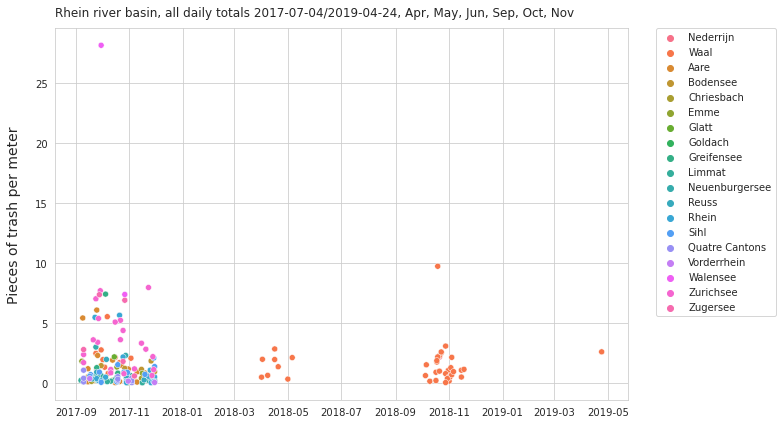

In [23]:
sns.set_style('whitegrid')

# a_results_dfx['country'] = 'nl'
# survey_total_ch['country'] = 'ch'

daily_totals = pd.concat([a_results_dfx, survey_total_ch])

data = daily_totals[daily_totals.month.isin([9,10,11,4,5,6])]
data = data[data.water_name != 'Maas']

fig, ax = plt.subplots(figsize=(11,6))

sns.scatterplot(data=data, x='date', y='pcs_m', hue='water_name', palette='husl', ax=ax)

ax.set_title(F"Rhein river basin, all daily totals {a_min_date.date()}/{a_max_date.date()}, Apr, May, Jun, Sep, Oct, Nov", **title_k)
ax.set_ylabel("Pieces of trash per meter", **ylab_k)
ax.set_xlabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
a_name = F"{project_directory}/initial_harmonized_results.jpg"
plt.savefig(a_name, dpi=300)

plt.show()
plt.close()


### These are the unaccounted for dutch surveys (no date):

In [24]:
no_date_dutch_surveys

,Unnamed: 0,Gebiedscode,Rivier,Coordinaten,Lat,Lon,meting,date,doy,dop,...,sanitair_overig_sanitair,medisch_verpakkingen,medisch_spuiten,medisch_overig_medisch,Unnamed: 121,Totaal,Items/km,granulaat_korrels,new date,this date
153,155,W(042a)L-GENL,Waal,#REF!,51.8872,5.4663,2,0,NaN,NaN,...,0,0,0,0,NaN,55,550,0,0,nothing
155,157,W(038a)L-GENL,Waal,#REF!,51.8897,5.5208,2,0,NaN,NaN,...,1,0,0,0,NaN,143,1430,0,0,nothing
181,184,M(122a)L-NBNL,Maas,#REF!,51.7444,5.3194,2,0,NaN,NaN,...,0,0,0,0,NaN,256,2560,1,0,nothing
246,259,W(039a)L-GENL,Waal,#REF!,51.8876,5.4978,3,0,NaN,NaN,...,0,0,0,0,NaN,336,3360,0,0,nothing
270,285,W(008a)L-GENL,Waal,#REF!,51.7183,4.6980,3,0,NaN,NaN,...,0,0,0,0,NaN,106,1060,4,0,nothing
288,303,M(149a)L-NBNL,Maas,#REF!,51.7175,4.9081,3,0,NaN,NaN,...,0,0,0,0,NaN,103,1030,0,0,nothing
383,400,M(009a)R-LINL,Maas,#REF!,50.9022,5.6980,3,0,NaN,NaN,...,0,4,0,0,NaN,410,4100,0,0,nothing


### Change the object definitions to OSPAR codes

The objects definitions need to changed to OSPAR

In [25]:
## !!! refresh the data from the hammerdirt api here:

# a = requests.get('https://mwshovel.pythonanywhere.com/api/surveys/daily-totals/code-totals/swiss/')
# b = requests.get('https://mwshovel.pythonanywhere.com/api/list-of-beaches/swiss/')
# c = requests.get('https://mwshovel.pythonanywhere.com/api/mlw-codes/list/')

# # the surveys need to be unpacked:
# swiss_surveys = ut.unpack_survey_results(a.json())
# swiss_surveys = pd.DataFrame(swiss_surveys)

# # adding location date column
# swiss_surveys['loc_date'] = list(zip(swiss_surveys['location'], swiss_surveys['date']))

# # hold the original
# x = a.json()

# print("survey columns")
# print(swiss_surveys.columns)

# swiss_beaches = pd.DataFrame(b.json())
# print("beach columns")
# print(swiss_beaches.columns)

# print("code columns")
# swiss_codes = pd.DataFrame(c.json())
# print(swiss_codes.columns)

# swiss_surveys.to_csv(data+'/hammerdirt_data.csv')
# swiss_beaches.to_csv(beaches+'/hammerdirt_beaches.csv')
# swiss_codes.to_csv(codes+'/swiss_codes.csv')
